<a href="https://colab.research.google.com/github/vincentbonnetai/notebooks/blob/main/eigen_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EigenFaces: Face Recognition with Principal Component Analysis (PCA)

Face recognition is an important field in computer vision with numerous real-world applications, from unlocking your smartphone to enhancing security systems. Principal Component Analysis (PCA) is a powerful technique used to extract essential features from high-dimensional data.

In this notebook, we delve into the world of EigenFaces—a landmark approach in the realm of facial recognition. EigenFaces leverages PCA to represent faces as linear combinations of eigenfaces, which are the principal components of a training dataset. By using eigenfaces, we can reduce the dimensionality of facial data while retaining crucial information, allowing us to perform efficient and accurate face recognition.

Throughout this notebook, we will explore:

1. Olivetti Faces Dataset
2. Facial Image Transformation into a Novel Embedding Space (Face Space)
3. Development of the Machine Learning Model for Facial Recognition
4. Inference of the Model for Face Recognition
5. Model Performance Evaluation




## Packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets

## Load and Visualize Olivetti Faces Dataset

Load the Olivetti faces data-set from AT&T. The dataset contains :

40 identities
400 images
image size is 64x64 (4096 pixels)
image pixel values are normalized

There are 40 unique faces
There are 400 faces
The single image size is (64, 64) 
The data range is [0.0,1.0]
X shape is (400, 4096)
y shape is (400,)


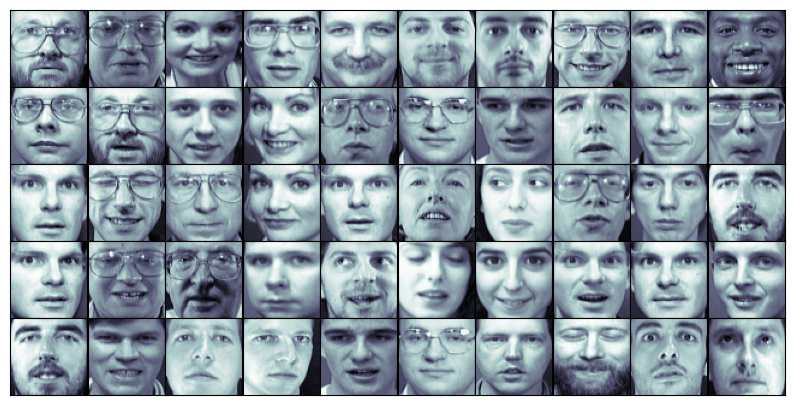

In [2]:
# Load dataset
bunch = datasets.fetch_olivetti_faces(return_X_y=False, shuffle=True)
X = bunch.data
y = bunch.target

NUM_EXAMPLES = X.shape[0]
NUM_UNIQUE_FACES = len(np.unique(y))
IMAGE_SHAPE = bunch.images.shape[1:]

# Print dataset informations
print("There are {} unique faces".format(NUM_UNIQUE_FACES))
print("There are {} faces".format(NUM_EXAMPLES))
print("The single image size is {} ".format(IMAGE_SHAPE))
print("The data range is [{},{}]".format(np.min(X), np.max(X)))
print("X shape is {}".format(X.shape))
print("y shape is {}".format(y.shape))

# Visualize few faces
def show_images(data_x):
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
        image = data_x[i].reshape(IMAGE_SHAPE)
        ax.imshow(image, cmap=plt.cm.bone)

show_images(X)

Lets visualize a specific identities

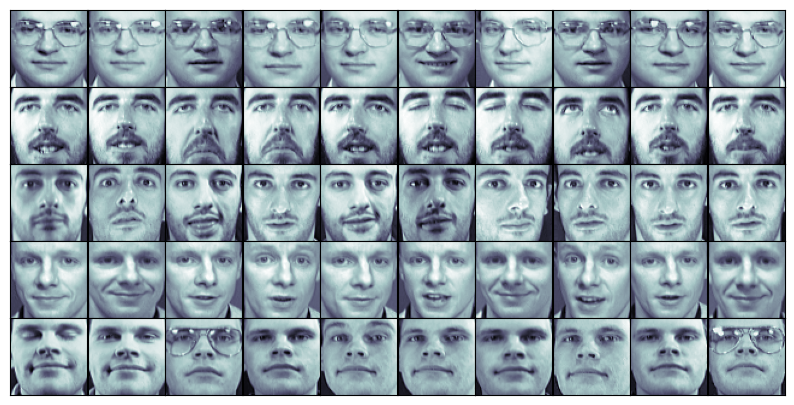

In [3]:
def show_identity(data_x, identities):
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(wspace=0, hspace=0)
    i = 0
    for identity in identities:
        ids = np.argwhere(y == identity).flatten()
        for idx in range(10):
            ax = fig.add_subplot(len(identities), 10, i + 1, xticks=[], yticks=[])
            image = data_x[ids[idx]].reshape(IMAGE_SHAPE)
            ax.imshow(image, cmap=plt.cm.bone)
            i = i + 1
    plt.show()

show_identity(X, identities = [5, 10, 15, 20, 35])

## Prepare dataset (Training & Test sets)